In [275]:
%matplotlib inline
from collections import defaultdict, Counter
import glob
import os
import json

from IPython.core.display import HTML, Image
from matplotlib_venn import venn3
import pandas as pd
import pybedtools
import pysam
import gspread
from gscripts.general import parsers
from gscripts.general import dataviz
%load_ext autoreload
%autoreload 2
reload(parsers)
reload(pybedtools)
import seaborn as sns

from oauth2client.client import SignedJwtAssertionCredentials

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [276]:
json_key = json.load(open("../public clip-588adbc137f3.json"))
scope = ['https://spreadsheets.google.com/feeds']

credentials = SignedJwtAssertionCredentials(json_key['client_email'], json_key['private_key'], scope)
gc = gspread.authorize(credentials)

sht1 = gc.open_by_url("https://docs.google.com/spreadsheets/d/1ZU2mQh54jentqvhR_oMnviLGWR8Nw_x338gULzKjNDI/edit#gid=0")
ws = sht1.worksheet("Sheet1")
list_of_lists = ws.get_all_values()
manifest = pd.DataFrame(list_of_lists[1:], columns=list_of_lists[0])
manifest['qc_id'] = manifest.apply(lambda x: "{}_{}".format(x.ENCODE_ID, x.RBP), axis=1)
manifest.is_encode = manifest.is_encode == "TRUE"

In [277]:
def format_file(index, adapter):
    index_1 = illumina_adapters.ix[index.index_1].values[0]
    index_2 = illumina_adapters.ix[index.index_2].values[0]
    if index.Lane == "": #Incase we are doing a rapid run and there isn't lane info
        sample_name = "{}_{}-{}_{}.fastq.gz".format(index.Hiseq_file_name, index_2, index_1, adapter)
        dir_name = "Sample_{}".format(index.Hiseq_file_name)

    elif index.Lane.startswith("S"):
        name = index.Hiseq_file_name.split("-")[0].replace("_", "-")
        sample_name = "{}_{}_{}.fastq.gz".format(name, index.Lane, adapter)
        dir_name = index.Hiseq_file_name

    else:
        sample_name = "{}_{}-{}_{}_{}.fastq.gz".format(index.Hiseq_file_name, index_2, index_1, index.Lane, adapter)
        dir_name = "Sample_{}".format(index.Hiseq_file_name)
    return os.path.join(index.file_location, dir_name, sample_name)

In [278]:
analysis_dir = "/home/gpratt/projects/encode/analysis/encode_v8/"
encode_v7 = parsers.clipseq_metrics(analysis_dir, iclip=True)

encode_v7["Fraction Collapsed"] = encode_v7['Usable Reads'] / encode_v7['Uniquely Mapped Reads'].astype(float)
encode_v7["Fraction Usable"] = encode_v7['Usable Reads'] / encode_v7['Input Reads'].astype(float)
unmerged_clip_manifest = encode_v7[["merged" not in index for index in encode_v7.index]]

manifest_df = pd.read_table("/home/gpratt/projects/encode/scripts/encode_v8.txt", header=None,
             names=['fastq', 'species', 'encode_id', 'barcodes', 'barcodes_len', 'more_barcodes'])
manifest_df['qc_name'] = manifest_df.fastq.apply(lambda x: ".".join(os.path.basename(x.split(";")[0]).split(".")[:2]))

tmp = pd.merge(manifest_df, unmerged_clip_manifest, left_on="qc_name", right_index=True)

final_qc_frame = pd.merge(manifest, tmp, left_on='qc_id', right_on='encode_id')
final_qc_frame['exp_id'] = final_qc_frame.ENCODE_ID.apply(lambda x:x.split("_")[0])
final_qc_frame['rep_num'] = final_qc_frame.ENCODE_ID.apply(lambda x:x.split("_")[1])

In [289]:
new_index = []
for index, row in final_qc_frame.iterrows():
    new_index.append([row.RBP, row.exp_id, row.rep_num, row.cell_type])
    
final_qc_frame.index = pd.MultiIndex.from_tuples(new_index, names=['rbp', 'encode_id', 'rep', 'cell_type'])
final_qc_frame = final_qc_frame.sort_index()

In [305]:
filtered_final_qc_frame = final_qc_frame[[ "Input Reads",
                                #'Trimmed bases',
                            "Reads Written",
                            "repetitive_count",
                            "Uniquely Mapped Reads",
                            #"Uniquely mapped reads %",
                            "Usable Reads",
                            "Fraction Collapsed",
                            "Fraction Usable",
                            #"spot",
                            "Num Peaks",
                            #"Passed QC"
                            ]]

filtered_final_qc_frame = filtered_final_qc_frame.astype(float)

In [306]:
HTML(filtered_final_qc_frame.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads Written" : parsers.commas,
                                     "repetitive_count": parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     "Usable Reads" : parsers.commas,
                                     "Num Peaks": parsers.commas
                                     } ))

In [307]:
final_qc_frame.to_csv("/home/gpratt/projects/encode/analysis/encode_v8/master_qc.csv")

In [ ]:
with dataviz.Figure("foo.svg", figsize=(10, 50)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(filtered_final_qc_frame,  ax=ax)

In [414]:
filtered_final_qc_frame

Input Reads  Reads Written  \
rbp       encode_id rep   cell_type                                
AIFM1     KB12      AIFM  FIXME          10276666        9952948   
          KB2       AIFM  FIXME           4026626        3789739   
                          FIXME           3888015        3648828   
          KB3       AIFM  FIXME          10333989        9646717   
                          FIXME           7838299        7347020   
ASCC1     219       02    HepG2           3842217        3490186   
                          HepG2           3080568        2864636   
                    INPUT HepG2          14060169       13742528   
          323       01    K562              16325          10739   
                          K562            2598984        2469473   
                    02    K562            7003008        6612656   
                          K562            2344342        2198486   
                    INPUT K562           10914914       10558369   
AUH       246       01    K562            9848178        8304018   
                          K562            3783411        3268230   
                    02    K562            6231109        5272954   
                          K562            7619024        6318900   
                    INPUT K562           22738181       22136900   
          280       01    HepG2           7038518        6715567   
                          HepG2           6514714        6254670   
                    02    HepG2          11802076       10398865   
                          HepG2           3691361        3314186   
                    INPUT HepG2          19066270       18617190   
BCCIP     230       01    HepG2           5060928        4691932   
                          HepG2           3883159        3598161   
                    02    HepG2           5167396        4904084   
                          HepG2           3829240        3662526   
                    INPUT HepG2          13799992       13530173   
          254       01    K562            5233896        4784937   
                          K562            5771725        5219588   
...                                           ...            ...   
XRN2      245       01    K562            6497043        6153419   
                    02    K562            3346607        3183064   
                          K562            3983441        3791518   
                    INPUT K562           13808829       13514767   
YB1       EVN       YB1   293XT           6313391        5607535   
                          293XT           4733693        4286358   
                          293XT           5523694        5450948   
          Skin      CLIP  SenLabSkin     15366363       12000907   
                          SenLabSkin     10491072        7991064   
hnRNPA2B1 F1        IN    FIXME          14925547       14071190   
                    IP    FIXME           6170630        4512868   
                          FIXME           4228769        3203237   
          F2        IN    FIXME          12414937       11680698   
                    IP    FIXME           6809024        5326269   
                          FIXME           3774086        3132940   
          F3        IN    FIXME          18111907       17155325   
                    IP    FIXME           7054810        6335287   
                          FIXME           4456149        4024915   
          F4        IN    FIXME          17956341       16898313   
                    IP    FIXME          10430113        8924652   
                          FIXME           3213283        2826654   
          F5        IN    FIXME          10861702       10106160   
                    IP    FIXME           7713357        7021799   
                          FIXME           2916462        2651088   
          F6        IN    FIXME           8330843        7764906   
                    IP    FIXME           8596302        7727208   
                          

In [415]:
grouped_final_qc_frame = filtered_final_qc_frame.groupby(level=['rbp', 'encode_id', 'rep', 'cell_type']).sum()
grouped_final_qc_frame["Fraction Collapsed"] = grouped_final_qc_frame['Usable Reads'] / grouped_final_qc_frame['Uniquely Mapped Reads'].astype(float)
grouped_final_qc_frame["Fraction Usable"] = grouped_final_qc_frame['Usable Reads'] / grouped_final_qc_frame['Input Reads'].astype(float)
grouped_final_qc_frame = grouped_final_qc_frame.drop("Num Peaks", axis=1)

In [420]:
encode_only_qc = grouped_final_qc_frame[[item[0].isdigit() and item[-1].isdigit() for item in grouped_final_qc_frame.index.get_level_values(level="encode_id")]]
encode_only_qc = encode_only_qc.drop("R60")
encode_only_qc = encode_only_qc.drop('INPUT', level="rep")

In [417]:
HTML(grouped_final_qc_frame.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads Written" : parsers.commas,
                                     "repetitive_count": parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     "Usable Reads" : parsers.commas,
                                     "Num Peaks": parsers.commas
                                     } ))

In [304]:
grouped_final_qc_frame[grouped_final_qc_frame['Usable Reads'] < 1000000]

Input Reads  Reads Written  \
rbp     encode_id cell_type                                
AIFM1   KB12      FIXME          10276666        9952948   
        KB2       FIXME           7914641        7438567   
DDX6    Skin      SenLabSkin     11977374       10707297   
EIF4A3  EVN       293XT           5662284        5596971   
HNRNPA1 EVN       293XT           5388978        5319332   
                  H1ES            5124355        5049055   
IgG     Skin      SenLabSkin      8982279        7491879   
        Stefan    H9ES            6902662        5072821   
R60     10        GM12878        27352556       21421039   
        12        GM12878        19398314       15617370   
        14        GM12878        19379594       17795662   
        16        GM12878        19884460       17841057   
        6         K562           21709104       18201175   
RBM34   231       HepG2           9747083        9351780   
SF3B4   EVN       293XT           5656147        5583510   

                              Uniquely Mapped Reads  Usable Reads  \
rbp     encode_id cell_type                                         
AIFM1   KB12      FIXME                      902723        858679   
        KB2       FIXME                      722475        706628   
DDX6    Skin      SenLabSkin                1590684        904499   
EIF4A3  EVN       293XT                     1102753        700929   
HNRNPA1 EVN       293XT                      927048        589998   
                  H1ES                      1314010        845269   
IgG     Skin      SenLabSkin                1464174        505833   
        Stefan    H9ES                      1838980        431079   
R60     10        GM12878                   2629880        974938   
        12        GM12878                   2036433        871577   
        14        GM12878                   2439609        998799   
        16        GM12878                   2329060        834998   
        6         K562                      3352179        985181   
RBM34   231       HepG2                     1052740        735714   
SF3B4   EVN       293XT                     1252808        802441   

                              Fraction Collapsed  Fraction Usable  
rbp     encode_id cell_type                                        
AIFM1   KB12      FIXME                 0.951210         0.083556  
        KB2       FIXME                 0.978066         0.089281  
DDX6    Skin      SenLabSkin            0.568623         0.075517  
EIF4A3  EVN       293XT                 0.635617         0.123789  
HNRNPA1 EVN       293XT                 0.636427         0.109482  
                  H1ES                  0.643274         0.164951  
IgG     Skin      SenLabSkin            0.345473         0.056315  
        Stefan    H9ES                  0.234412         0.062451  
R60     10        GM12878               0.370716         0.035643  
        12        GM12878               0.427992         0.044931  
        14        GM12878               0.409409         0.051539  
        16        GM12878               0.358513         0.041992  
        6         K562                  0.293893         0.045381  
RBM34   231       HepG2                 0.698856         0.075480  
SF3B4   EVN       293XT                 0.640514         0.141871

#Public CLIP QC

In [308]:
analysis_dir = "/home/gpratt/projects/public_clip/analysis/public_clip_v9/"
public_clip = parsers.clipseq_metrics(analysis_dir, iclip=True)

public_clip["Fraction Collapsed"] = public_clip['Usable Reads'] / public_clip['Uniquely Mapped Reads'].astype(float)
public_clip["Fraction Usable"] = public_clip['Usable Reads'] / public_clip['Input Reads'].astype(float)
unmerged_public_clip_manifest = public_clip[["merged" not in index for index in public_clip.index]]



/home/gpratt/projects/public_clip/analysis/public_clip_v9/ERR208893.GGG.polyATrim.adapterTrim.metrics

/home/gpratt/projects/public_clip/analysis/public_clip_v9/ERR208898.CAAT.polyATrim.adapterTrim.metrics


In [309]:
filtered_unmerged_public_clip_manifest = unmerged_public_clip_manifest[[ "Input Reads",
                                #'Trimmed bases',
                            "Reads Written",
                            "repetitive_count",
                            "Uniquely Mapped Reads",
                            #"Uniquely mapped reads %",
                            "Usable Reads",
                            "Fraction Collapsed",
                            "Fraction Usable",
                            #"spot",
                            "Num Peaks",
                            #"Passed QC"
                            ]]

filtered_unmerged_public_clip_manifest = filtered_unmerged_public_clip_manifest.astype(float)

In [310]:
HTML(filtered_unmerged_public_clip_manifest.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads Written" : parsers.commas,
                                     "repetitive_count": parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     "Usable Reads" : parsers.commas,
                                     "Num Peaks": parsers.commas
                                     } ))

,Input Reads,Reads Written,repetitive_count,Uniquely Mapped Reads,Usable Reads,Fraction Collapsed,Fraction Usable,Num Peaks
ERR018282.polyATrim,"2,610,554","2,582,733","2,593,238","1,431,706","313,534",0.218993,0.120102,"5,869"
ERR018283.CA,"66,022","65,400","117,905","37,144","6,122",0.164818,0.092727,38
ERR018284.GA,"17,669","17,521","30,536","9,419","1,429",0.151715,0.080876,13
ERR039833.TG,"266,483","263,875","1,071","4,513","1,646",0.364724,0.006177,9
ERR039834.CG,"292,233","287,271","7,647","5,874","1,085",0.184712,0.003713,17
ERR039835.TC,"95,517","93,031","7,183","7,643","2,434",0.318461,0.025482,87
ERR039836.TC,"1,161,916","1,141,954","345,543","765,320","338,656",0.442502,0.291463,"1,423"
ERR039837.TC,"8,238,622","8,144,369","2,557,742","3,949,372","774,362",0.196072,0.093992,"8,009"
ERR039838.TC,"1,094,384","1,070,309","459,870","696,175","83,171",0.119469,0.075998,914
ERR039839.CG,"823,710","798,132","245,971","332,118","116,000",0.349273,0.140826,925


In [356]:
reload(parsers)

<module 'gscripts.general.parsers' from '/home/gpratt/gscripts/gscripts/general/parsers.pyc'>

In [357]:
analysis_dir = "/home/gpratt/projects/encode/analysis/v10/"
old_encode = parsers.clipseq_metrics(analysis_dir, iclip=True)

old_encode["Fraction Collapsed"] = old_encode['Usable Reads'] / old_encode['Uniquely Mapped Reads'].astype(float)
old_encode["Fraction Usable"] = old_encode['Usable Reads'] / old_encode['Input Reads'].astype(float)
unmerged_old_encode_manifest = old_encode[[len(index.split(".")[1].split("_")) > 1 for index in old_encode.index]]

In [315]:
import seaborn as sns

In [397]:
img_dir = "/home/gpratt/for_eric/"

#Show that the total number of usable reads is far and away better than other non-encode stuff

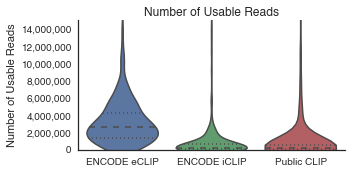

In [424]:
num_rows = 1 
num_cols = 2 
with dataviz.Figure(os.path.join(img_dir, "usable_reads_plots.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.violinplot([encode_only_qc['Usable Reads'], 
                    unmerged_old_encode_manifest['Usable Reads'].dropna(),
                    filtered_unmerged_public_clip_manifest['Usable Reads'].dropna()], ax=ax,
                  names=['ENCODE eCLIP', 
                         "ENCODE iCLIP", 
                         'Public CLIP'], fontsize=10)
    ax.set_ylim(0,15000000)
    xx = ax.get_yticks()
    ll = ['{:,d}'.format(int(a)) for a in xx]
    ax.set_yticklabels(ll, fontsize=10)
    sns.despine(ax=ax)
    ax.set_title("Number of Usable Reads", fontsize=12)
    ax.set_ylabel("Number of Usable Reads")
    

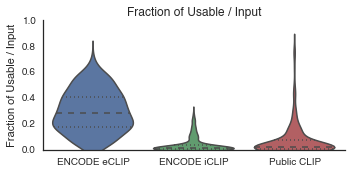

In [425]:
num_rows = 1 
num_cols = 2 
with dataviz.Figure(os.path.join(img_dir, "fraction_usable_reads_plots.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.violinplot([encode_only_qc['Fraction Usable'], 
                    unmerged_old_encode_manifest['Fraction Usable'].dropna(),
                    filtered_unmerged_public_clip_manifest['Fraction Usable'].dropna()], ax=ax,
                  names=['ENCODE eCLIP', 
                         "ENCODE iCLIP", 
                         'Public CLIP'], fontsize=10)
    ax.set_ylim(0,1)
    #xx = ax.get_yticks()
    #ll = ['{:,d}'.format(int(a)) for a in xx]
    #ax.set_yticklabels(ll, fontsize=10)
    sns.despine(ax=ax)
    ax.set_title("Fraction of Usable / Input", fontsize=12)
    ax.set_ylabel("Fraction of Usable / Input")

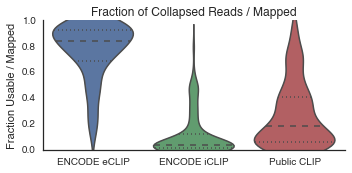

In [426]:
num_rows = 1 
num_cols = 2 
with dataviz.Figure(os.path.join(img_dir, "fraction_collapsed_reads.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.violinplot([encode_only_qc['Fraction Collapsed'], 
                    unmerged_old_encode_manifest['Fraction Collapsed'].dropna(),
                    filtered_unmerged_public_clip_manifest['Fraction Collapsed'].dropna()], ax=ax,
                  names=['ENCODE eCLIP', 
                         "ENCODE iCLIP", 
                         'Public CLIP'], fontsize=10)
    ax.set_ylim(0,1)
    #xx = ax.get_yticks()
    #ll = ['{:,d}'.format(int(a)) for a in xx]
    #ax.set_yticklabels(ll, fontsize=10)
    sns.despine(ax=ax)
    ax.set_title("Fraction of Collapsed Reads / Mapped", fontsize=12)
    ax.set_ylabel("Fraction Usable / Mapped")

In [427]:
encode_only_qc.to_csv("/home/gpratt/for_eric/encode_only_qc.csv")